# Simulations and analysis

In this notebook, we assess the performance of FL and FL with DP relative to baseline models.

In [123]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

%matplotlibotlib inline

from IPython.display import display

from mozfldp.client import Client
from mozfldp.model import SGDModel
#from mozfldp.server import ServerFacade
from mozfldp.simulation_runner import FLSimulationRunner

In [137]:
def load_dataset_from_file(csv_file):
    """Returns the dataset as a pandas DataFrame. """
    return pd.read_csv(csv_file)


def get_dataset_characteristics(df, label_col="label", user_id_col="user_id"):
    feature_cols = df.drop(columns=[label_col, user_id_col]).columns
    class_labels = df[label_col].unique()
    return {
        "n": len(df),
        "num_features": len(feature_cols),
        "num_classes": len(class_labels),
        "num_users": df[user_id_col].nunique(),
        "feature_cols": feature_cols,
        "class_labels": class_labels
    }

def summarize_dataset(df, df_info):
    display(df.head())
    print("\nNum training examples: {:,}".format(df_info["n"]))
    print("Num features: {:,}".format(df_info["num_features"]))
    print("Num classes: {:,}".format(df_info["num_classes"]))
    print("Num users: {:,}".format(df_info["num_users"]))
    
    print("\nLabels:")
    _ = (
        dataset_blob
        .groupby("label")
        .size()
        .plot.barh(
            legend=False,
            title="Num examples per label"
        )
    )
    plt.show()
    
    print("Users:")
    _ = (
        dataset_blob
        .groupby(["user_id", "label"])
        .size()
        .reset_index(name="n_examples")
        .pivot("user_id", "label", "n_examples")
        .plot.bar(
            stacked=True,
            title="Distribution of training examples per user",
            figsize=(20, 8)
        )
    )
    plt.show()
    
    print("Features:")
    dataset_blob.hist(
        column=df_info["feature_cols"],
        bins=50,
        figsize=(20, 10),
        sharex=True
    )
    plt.show()

## Initialization

First, initialize the various components to be used in running simulations.

In [139]:
BLOB_DATASET_PATH = "../datasets/blob_S20000_L3_F4_U100.csv"
TEST_DATA_PROP = 0.25

### Data

We begin with the "blob" dataset, a randomly generated dataset containing all numerical features grouped into meaningful labelled clusters. A baseline predictive model should perform very well on this data. Indiviual training examples were allocated across users unifomrly at random.

In [104]:
dataset_blob = load_dataset_from_file(BLOB_DATASET_PATH)
dataset_info = get_dataset_characteristics(dataset_blob)

,0,1,2,3,label,user_id
0,-0.525336,3.623456,1.680293,2.075983,0,45
1,9.534497,-8.348758,0.112068,6.815969,1,88
2,8.524880,-7.082612,-0.868522,5.211075,1,85
3,6.826851,-8.784989,0.090649,4.446359,1,18
4,-2.591003,5.138362,1.059329,1.319494,0,45



Num training examples: 20,000
Num features: 4
Num classes: 3
Num users: 100

Labels:


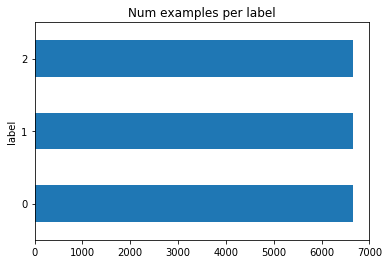

Users:


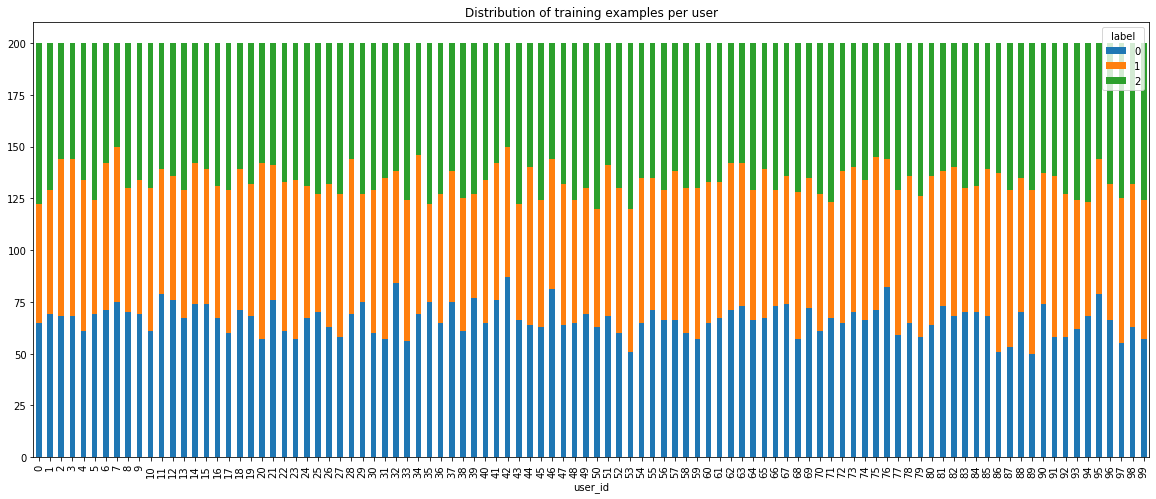

Features:


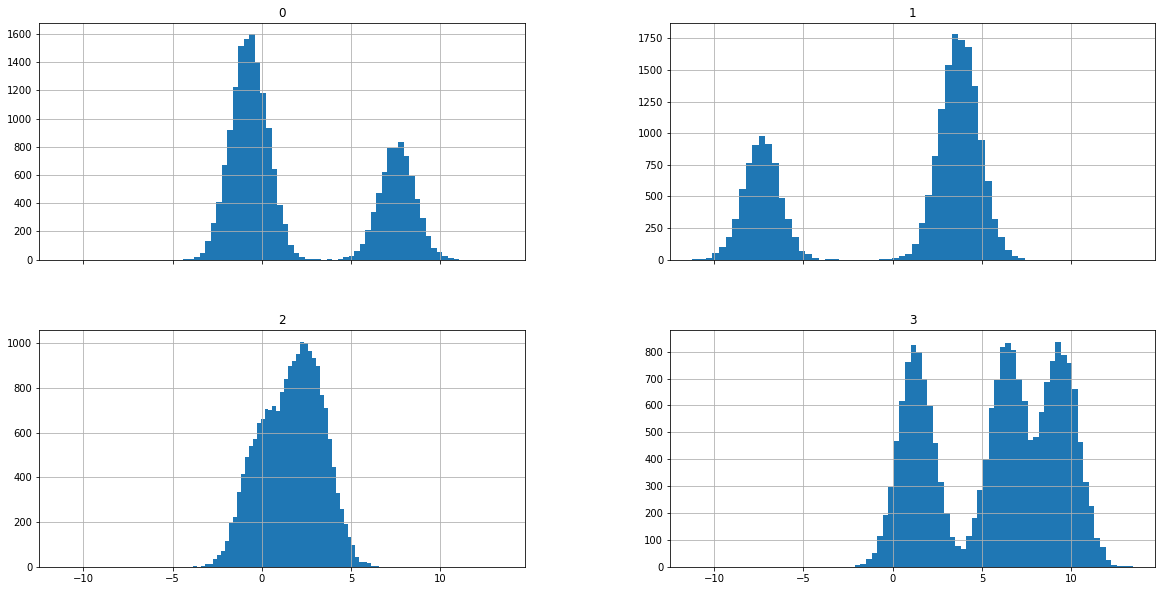

In [138]:
summarize_dataset(dataset_blob, dataset_info)

### Train/test split

Split the dataset by sampling users.

In [153]:
users_test = np.random.choice(
    dataset_blob["user_id"].unique(),
    size = int(dataset_info["num_users"] * TEST_DATA_PROP),
    replace=False
)

dataset_test = dataset_blob[dataset_blob["user_id"].isin(users_test)]
dataset_train = dataset_blob[~dataset_blob["user_id"].isin(users_test)]

### Standardize

Center and scale the features to unit variance.

In [191]:
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(dataset_train[dataset_info["feature_cols"]])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [197]:
for df in [dataset_train, dataset_test]:
    df.loc[:, dataset_info["feature_cols"]] = scaler.transform(df.loc[:, dataset_info["feature_cols"]])

/Users/dzeber/git/CANOSP-2019/.env/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/dzeber/git/CANOSP-2019/.env/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


### Model

Start with a linear SVM model.

In [200]:
sgd_model = SGDModel(
    loss="hinge",
    # shuffling shouldn't matter using our minibatch approach, but just in case
    shuffle=False,
    # default learning rate decays with the number of iterations
    learning_rate="optimal"
)

In [201]:
sgd_model

SGDModel(
SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=False, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
)

### Initial weights

Select initial model weights uniformly at random from the square with side [-1, 1].

In [208]:
def select_initial_weights(dataset_info, range_max=1):
    nrows = dataset_info["num_classes"]
    # Special case for 2 classes: single weight vector.
    if nrows == 2:
        nrows = 1
    init_weights = np.random.random_sample((nrows, dataset_info["num_features"] + 1))
    return init_weights[:, :-1], init_weights[:, -1]

In [212]:
init_coef, init_intercept = select_initial_weights(dataset_info)

In [214]:
print("Initial coefs")
print(init_coef)
print("\nInitial intercept")
print(init_intercept)

Initial coefs
[[0.79942851 0.87695174 0.42996018 0.95423285]
 [0.09319136 0.88694496 0.6682274  0.53138045]
 [0.08887405 0.11326229 0.37986448 0.96743977]]

Initial intercept
[0.32046218 0.76491633 0.8148854 ]
